<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, assign_wcs step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
import os
from astropy.io import fits

from jwst.assign_wcs.assign_wcs_step import AssignWcsStep

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/requirements.txt

# import NPTT
import nirspec_pipe_testing_tool as nptt

In [2]:
# Make sure that the version used is the right one

# to get the latest version from 'master' run:
# subprocess.run(['pip', 'install', 'git+https://github.com/spacetelescope/nirspec_pipe_testing_tool@master'])

latest_nptt_stable_version = '1.1.1'
nptt_version = nptt.__version__

if nptt_version != latest_nptt_stable_version:
    print("* WARNING - The code might break because the version used is not the latest stable version:")
    print("            Latest stable version is ", latest_nptt_stable_version)
    print("            Using NPTT version ", nptt_version)

* WARNING - The code might break because the version used is not the latest stable version:
            Latest stable version is  1.1.1
            Using NPTT version  1.1.1.dev4+gb2081e9


<a id="intro_ID"></a>
# Introduction

We compared Institute's pipeline product of the assign_wcs step with our benchmark files, or with the intermediary products from the ESA pipeline, which is completely independent from the Institute's. The comparison file is referred to as 'truth'. We calculated the relative difference and expected it to be equal to or less than computer precision:  relative_difference = absolute_value( (Truth - ST)/Truth )  <= 1x10^-7. 

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/compare_wcs_fs.py. For Multi Object Spectroscopy (MOS), the code is in the same repository but is named ```compare_wcs_mos.py```, and for Integral Field Unit (IFU) data, the test is named ```compare_wcs_ifu.py```.
The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information 


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing:
- FS_FULLFRAME_G395H_F290LP
- FS_ALLSLITS_G140H_F100LP
- MOS_G140M_LINE1
- IFU_G395H_F290LP

The testing data can be located at ```path_to_nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite```

In that directory you will find a subdirectory for CV3 data for FS, MOS, and IFU, as well as other campaigns. This notebook is specifically written for CV3 data.


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and assign_wcs validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the assign_wcs step, use the command:

$ strun jwst.assign_wcs.AssignWcsStep jwtest_rate.fits

NIRSpec TA data will be run through the cal_detector1 and the imaging2 pipelines. The imaging pipeline can be run with the following fommand:

$ strun jwst.pipeline.Image2Pipeline jwtest_rate.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
 
$\gt$ AssignWcsStep.call(jwtest_rate.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

NPTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use NPTT to run the pipeline and the validation tests. To run NPTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

-> For each mode, the following variables will need to be set:

- output_directory = path where you want intermediary files and plots to be saved in

- input_file = this is the previous step file, e.g. jwtest1_NRS1_rate.fits

- mode_used = supported modes are: FS, MOS, IFU, BOTS, MOS_sim, dark, image, confirm, taconfirm, wata, msata, focus, mimf

- raw_data_root_file = CV3 raw data file


<a id="common_vars"></a>
# Common Variables

In [3]:
# Set common variables for entire notebook

# paths
vault_path = os.path.join(os.environ.get('WIT4_PATH'), 'nirspec_vault')
test_data_path = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data'

# define benchmark (or 'truth') file
compare_assign_wcs_and_extract_2d_with_esa = False

# accepted threshold difference with respect to benchmark files
threshold_diff = 1e-7

# other variable
save_figs = False
show_figs = True

<a id="FULLFRAME"></a>
# FS FULL-FRAME test

In [7]:
# Set the variables for Fixed Slit (FS) data
data_directory = os.path.join(test_data_path, 'FS_FULL_FRAME/G395H_opaque/')
input_file = os.path.join(data_directory, 'final_output_caldet1_NRS1.fits')
mode_used = 'FS'
output_directory = 'somewhere_to_save_the_plots'

In [8]:
# ESA intermediary products
raw_data_root_file = 'NRSSMOS-MOD-G3H-02-5344120942_1_491_SE_2015-12-10T12h18m25.fits'
esa_files_path = os.path.join(vault_path, 'prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/')
esa_files_full_path = "".join([esa_files_path, mode_used, "_CV3_cutouts/ESA_Int_products"])

# pipeline intermediary products
truth_file = os.path.join(data_directory, 'final_output_caldet1_NRS1_assign_wcs_truth.fits')

if not compare_assign_wcs_and_extract_2d_with_esa:
    esa_files_path, raw_data_root_file = None, None
else:
    truth_file = None

In [9]:
# Run the pipeline step
step_output_file = input_file.replace(".fits", "_assign_wcs.fits")
pipe_result = AssignWcsStep.call(input_file)
#pipe_result.save(step_output_file)   # this is to save the pipeline output to a file

2020-09-25 12:38:59,515 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-09-25 12:38:59,518 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2020-09-25 12:38:59,580 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G395H_opaque/final_output_caldet1_NRS1.fits',).
2020-09-25 12:38:59,581 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-09-25 12:38:59,771 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1448970586061478 deg
2020-09-25 12:38:59,771 - stpipe.AssignWcsStep - INFO - gwa_x

Information from the 'truth' (or comparison) file 
Filename: /Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G395H_opaque/final_output_caldet1_NRS1_assign_wcs_truth.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     277   ()      
  1  SCI           1 ImageHDU        51   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [177114B]   
None
Comparing to ST 'truth' file.
from assign_wcs file  -->     Detector: NRS1   Grating: G395H   Filter: F290LP   Lamp: LINE3
GWA_XTILT: 0.3232757747173309
GWA_YTILT: 0.1448970586061478
GWA_TTILT: 37.16754109485964

Working with slit: S200A1


2020-09-25 12:39:44,459 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/auxiliary_functions.py:577: RuntimeWarning: invalid value encountered in less
  in_slit = np.logical_and(edy < .5, edy > -.5)

2020-09-25 12:39:44,460 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/auxiliary_functions.py:577: RuntimeWarning: invalid value encountered in greater
  in_slit = np.logical_and(edy < .5, edy > -.5)




   Relative Wavelength Difference  :   mean = nan    median = nan    stdev = nan
    Maximum   RelativeWavelength Difference = nan
    Minimum   RelativeWavelength Difference = nan
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  FAILED


   Relative Slit-Y Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeSlit-Y Difference = 0.000e+00
    Minimum   RelativeSlit-Y Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Slit-Y Difference:  PASSED


   Relative MSA_X Difference  :   mean = 0.000e+00    m

2020-09-25 12:39:44,809 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst162/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)

2020-09-25 12:39:44,810 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst162/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)




   Relative V2 difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeV2 difference = 0.000e+00
    Minimum   RelativeV2 difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for V2 difference:  PASSED


   Relative V3 difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeV3 difference = -0.000e+00
    Minimum   RelativeV3 difference = -0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for V3 difference:  PASSED

No output_directory was provided. Figures will be saved in current worki

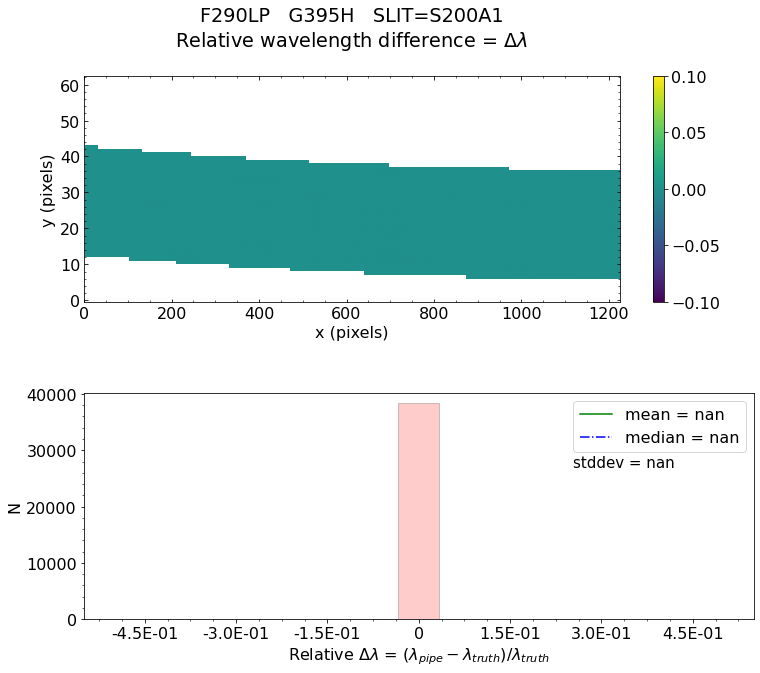

No output_directory was provided. Figures will NOT be saved.


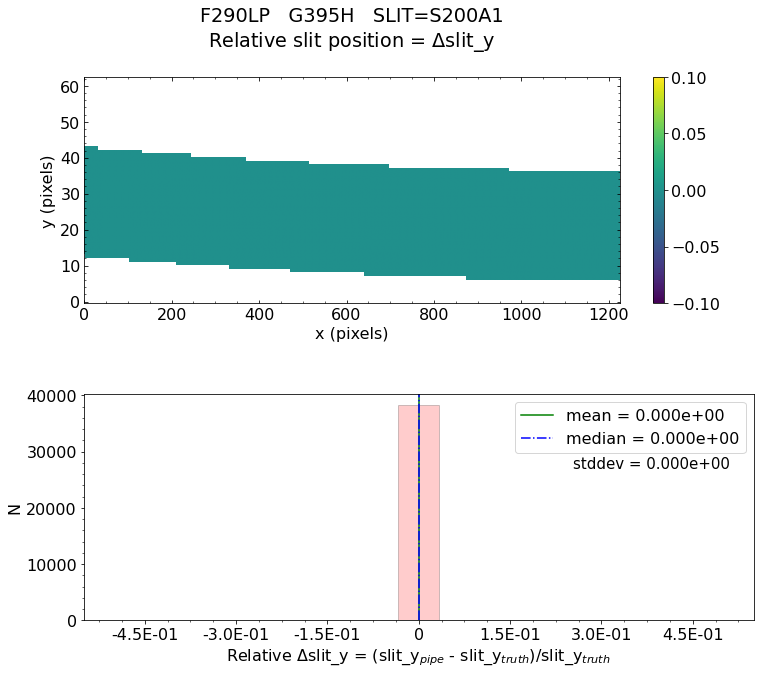

No output_directory was provided. Figures will NOT be saved.


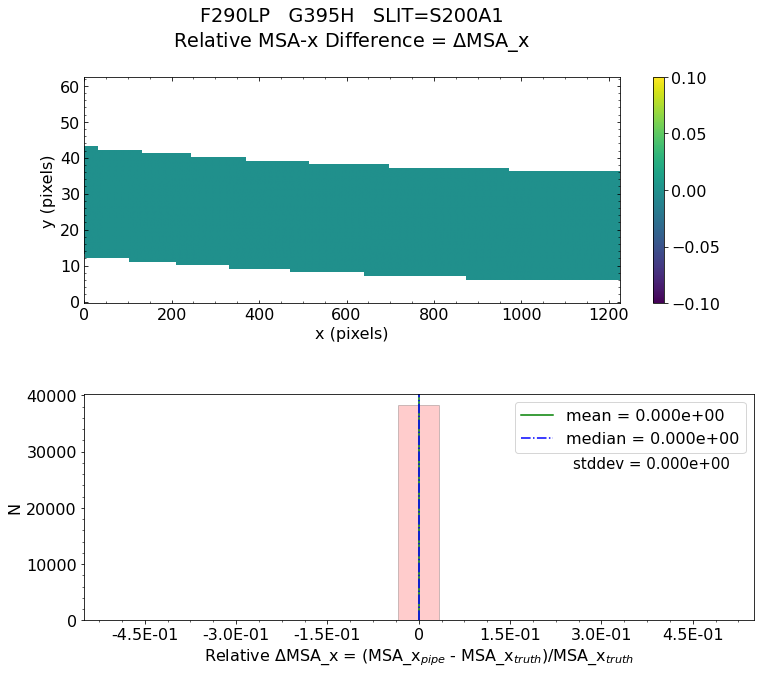

No output_directory was provided. Figures will NOT be saved.


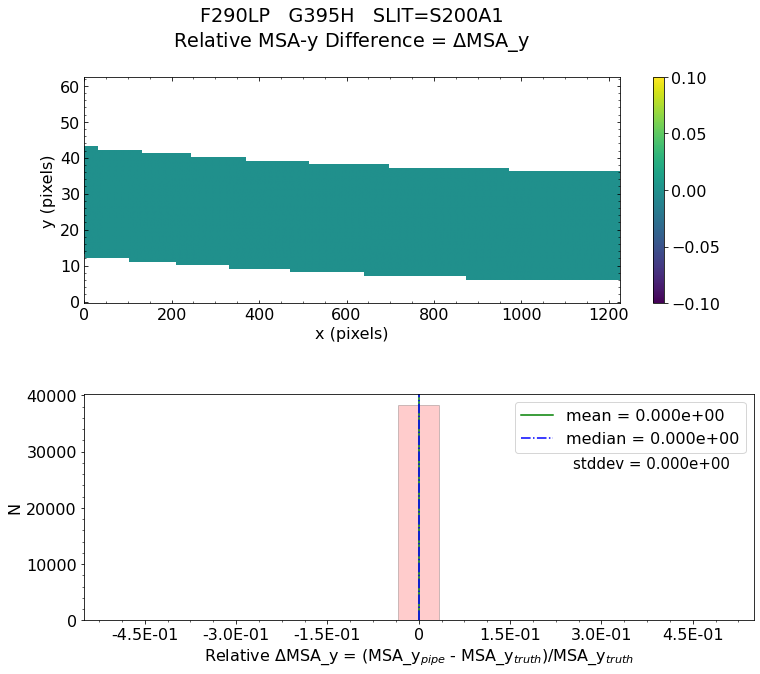

No output_directory was provided. Figures will NOT be saved.


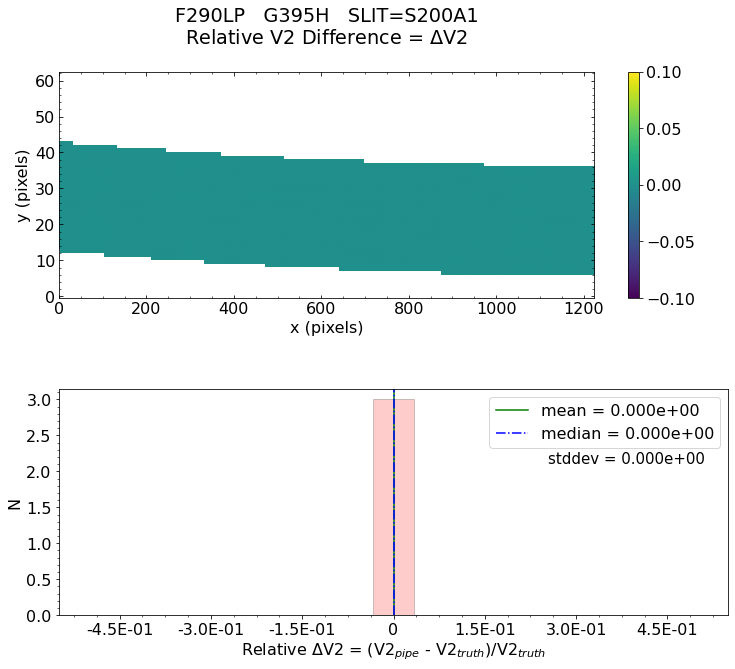

No output_directory was provided. Figures will NOT be saved.


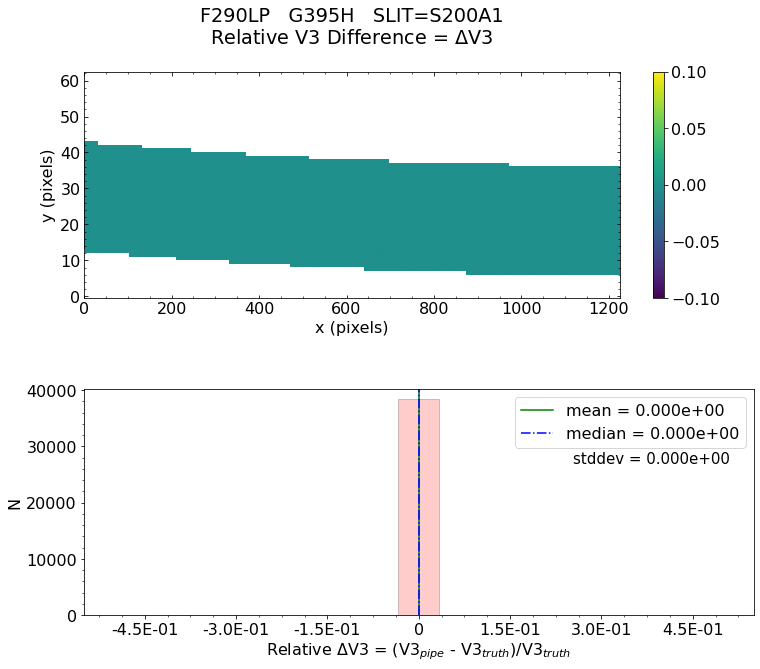


Working with slit: S200A2

   Relative Wavelength Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeWavelength Difference = 0.000e+00
    Minimum   RelativeWavelength Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  PASSED


   Relative Slit-Y Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeSlit-Y Difference = 0.000e+00
    Minimum   RelativeSlit-Y Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Slit-Y Difference:  PASSED


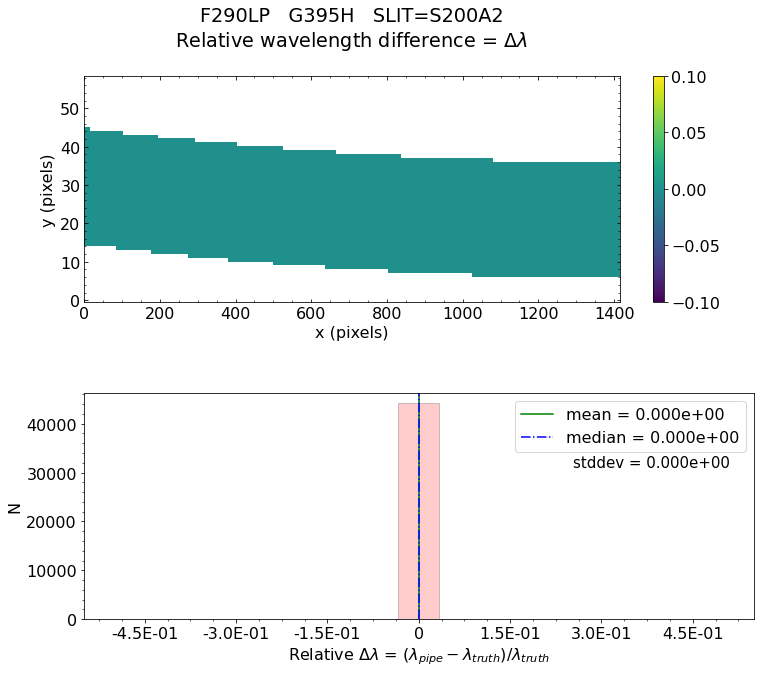

No output_directory was provided. Figures will NOT be saved.


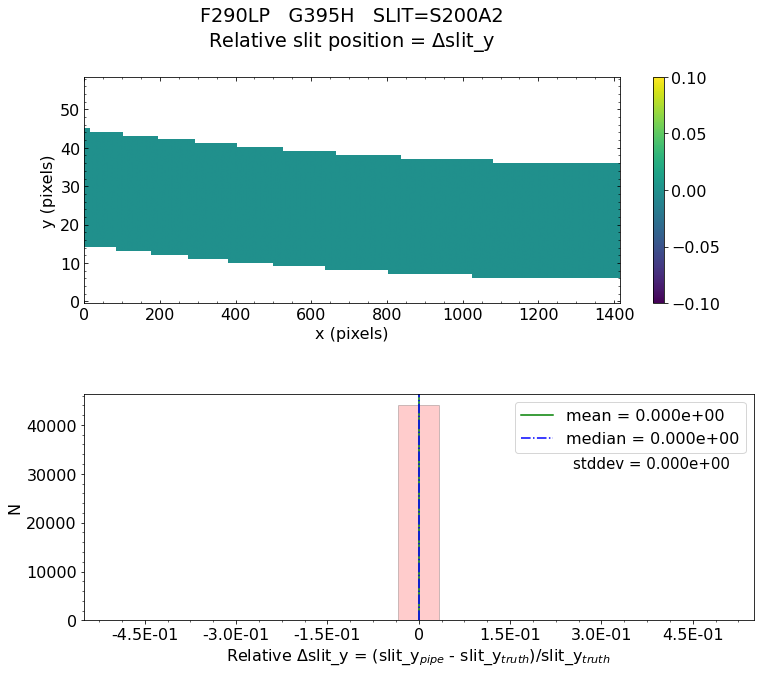

No output_directory was provided. Figures will NOT be saved.


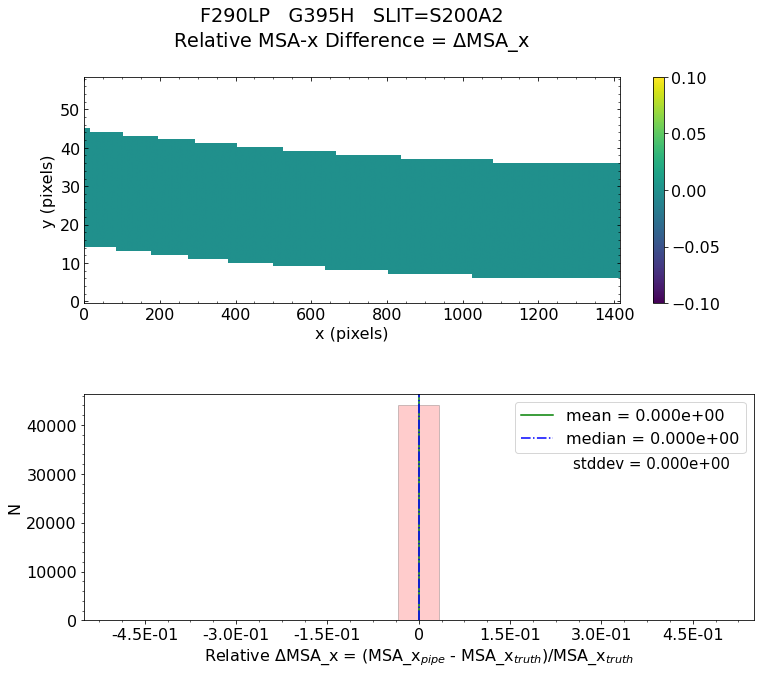

No output_directory was provided. Figures will NOT be saved.


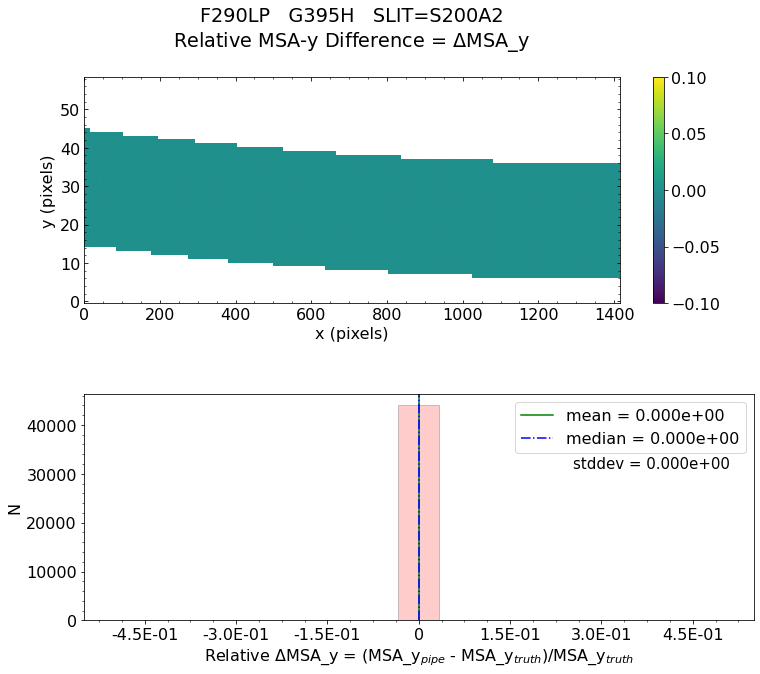

No output_directory was provided. Figures will NOT be saved.


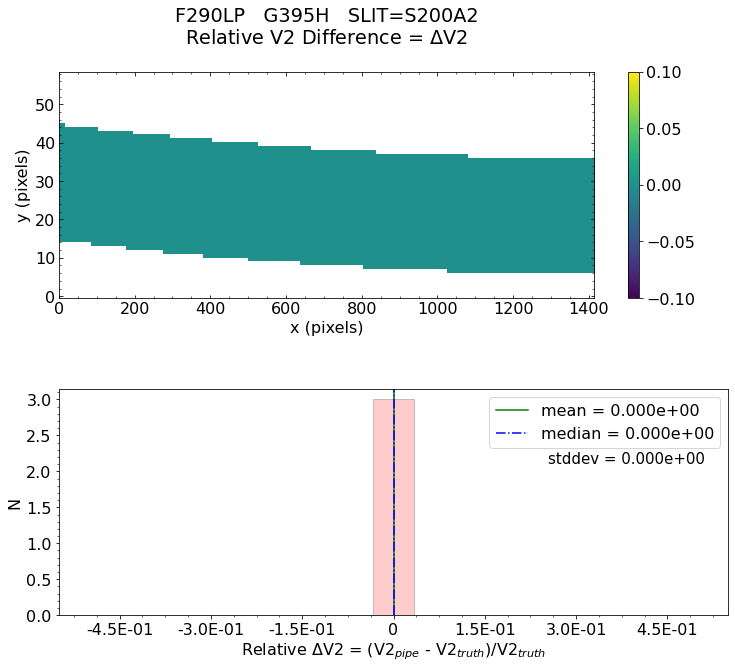

No output_directory was provided. Figures will NOT be saved.


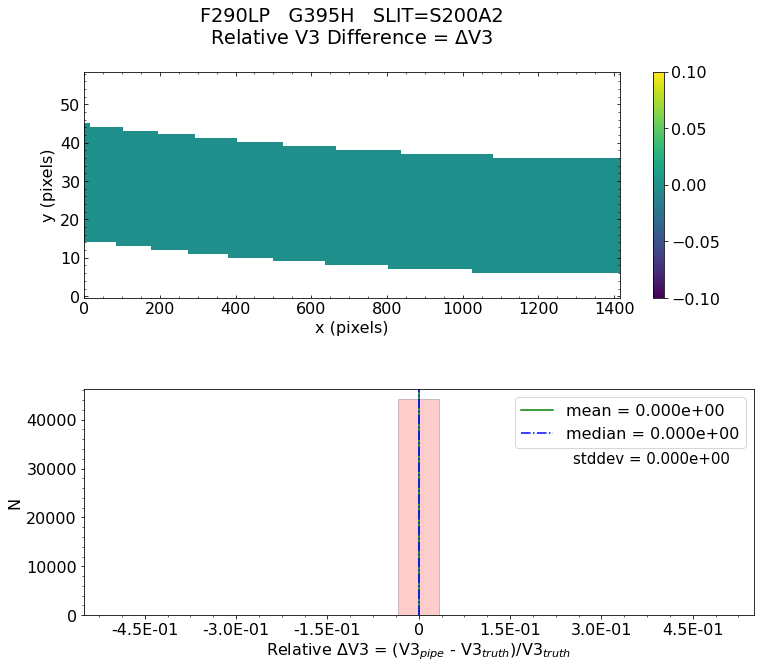


Working with slit: S400A1

   Relative Wavelength Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeWavelength Difference = 0.000e+00
    Minimum   RelativeWavelength Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  PASSED


   Relative Slit-Y Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeSlit-Y Difference = 0.000e+00
    Minimum   RelativeSlit-Y Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Slit-Y Difference:  PASSED


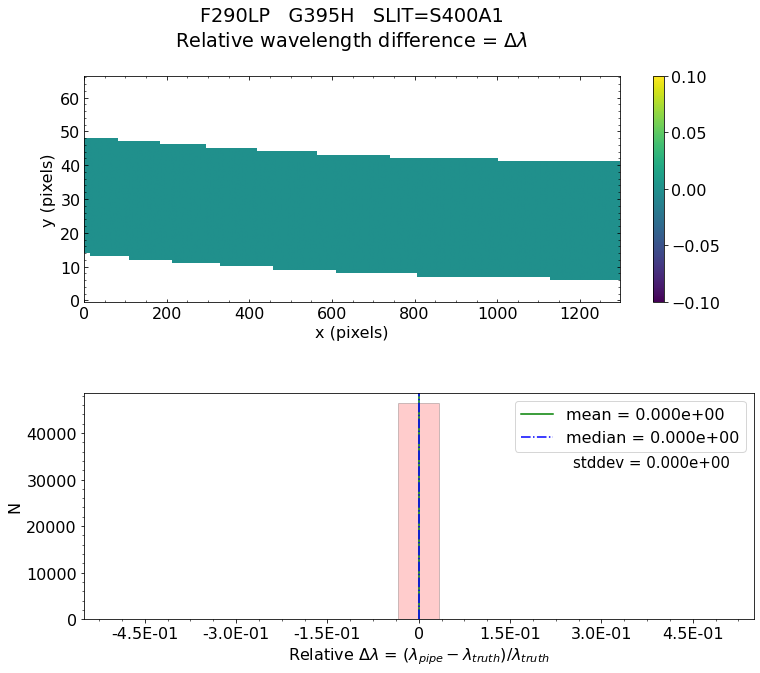

No output_directory was provided. Figures will NOT be saved.


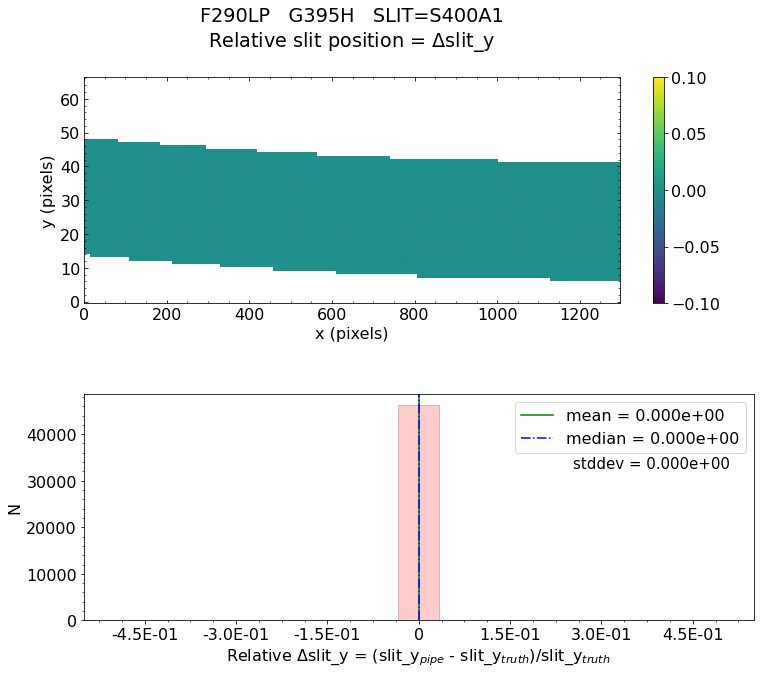

No output_directory was provided. Figures will NOT be saved.


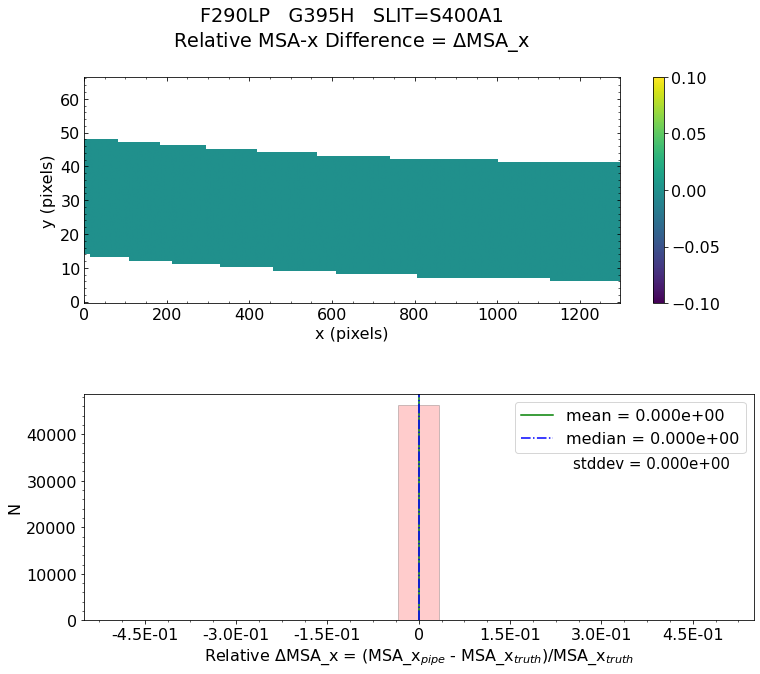

No output_directory was provided. Figures will NOT be saved.


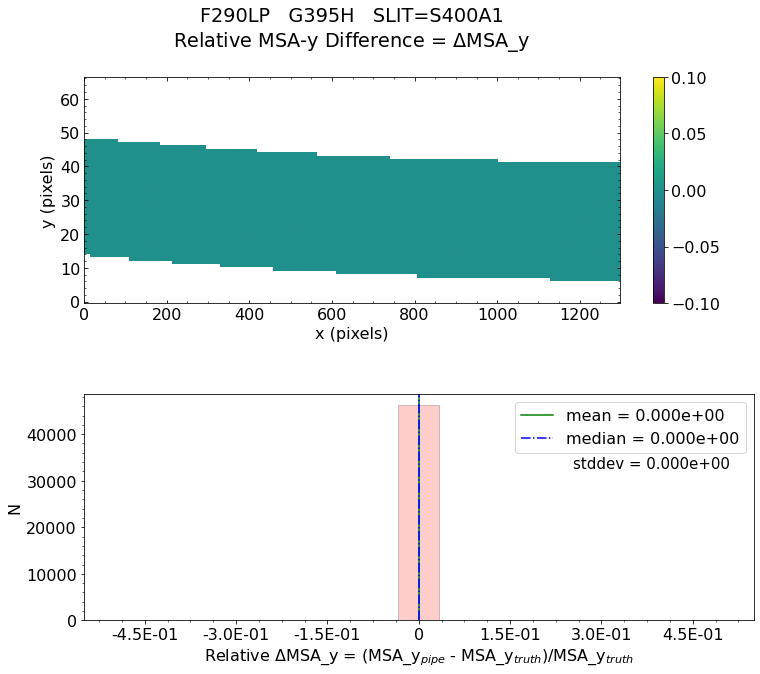

No output_directory was provided. Figures will NOT be saved.


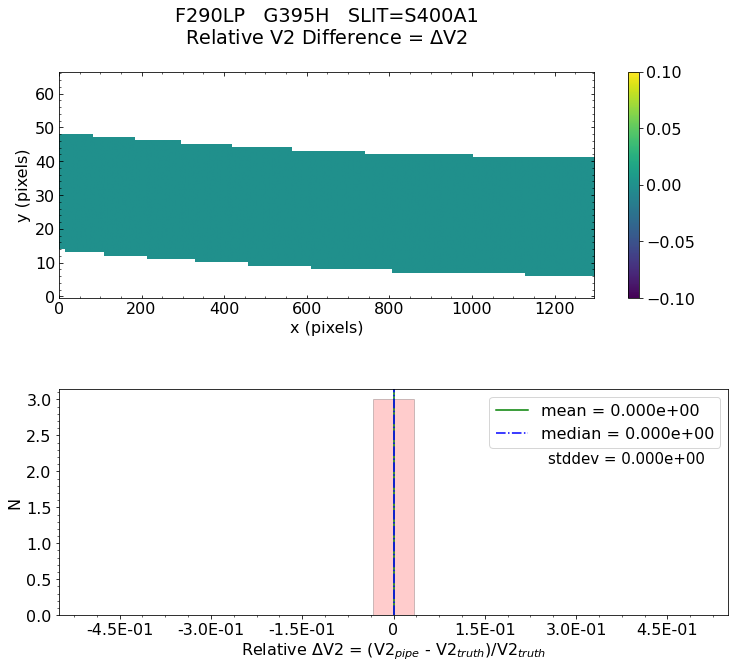

No output_directory was provided. Figures will NOT be saved.


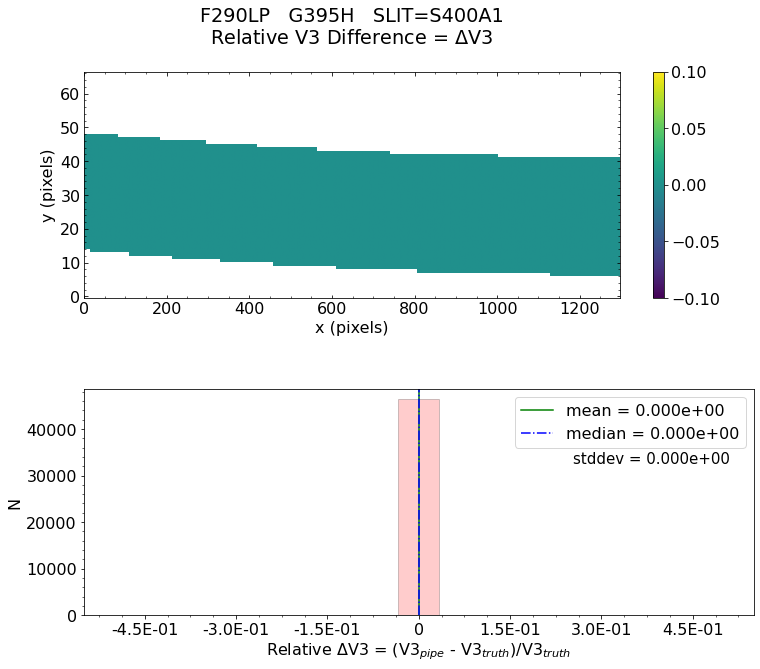


Working with slit: S1600A1

   Relative Wavelength Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeWavelength Difference = 0.000e+00
    Minimum   RelativeWavelength Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  PASSED


   Relative Slit-Y Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeSlit-Y Difference = 0.000e+00
    Minimum   RelativeSlit-Y Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Slit-Y Difference:  PASSED

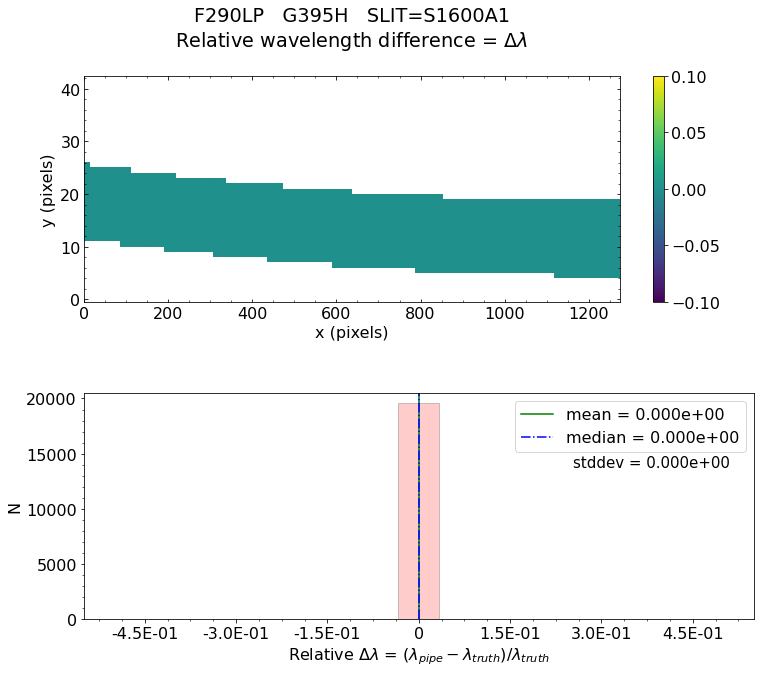

No output_directory was provided. Figures will NOT be saved.


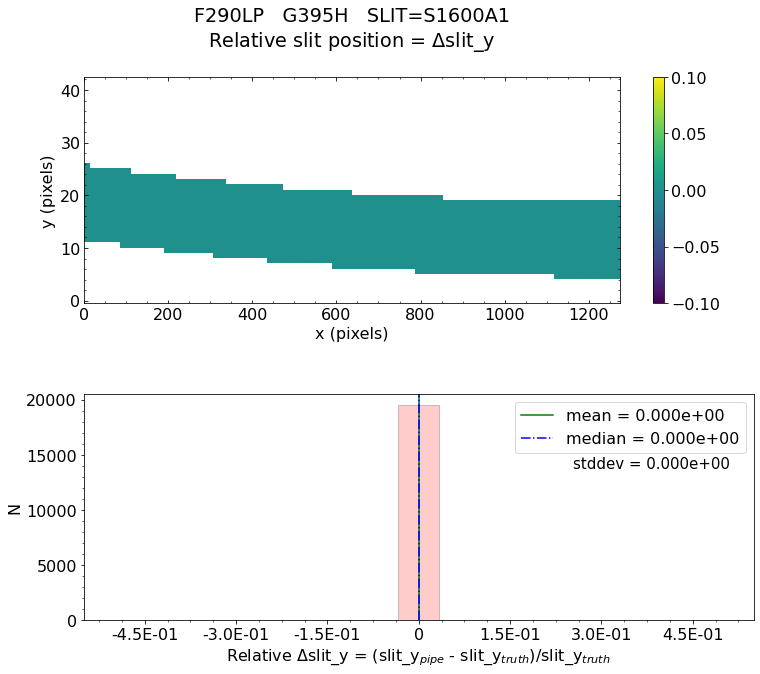

No output_directory was provided. Figures will NOT be saved.


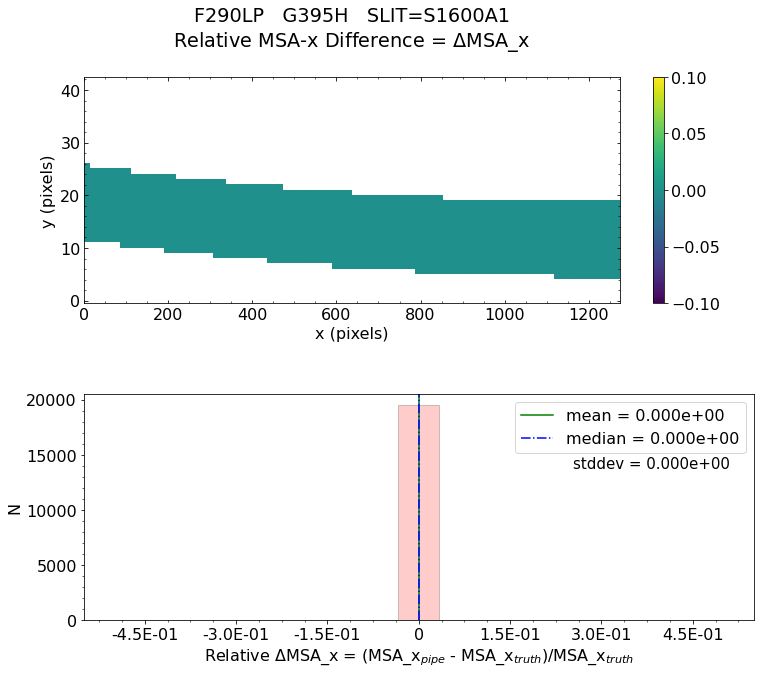

No output_directory was provided. Figures will NOT be saved.


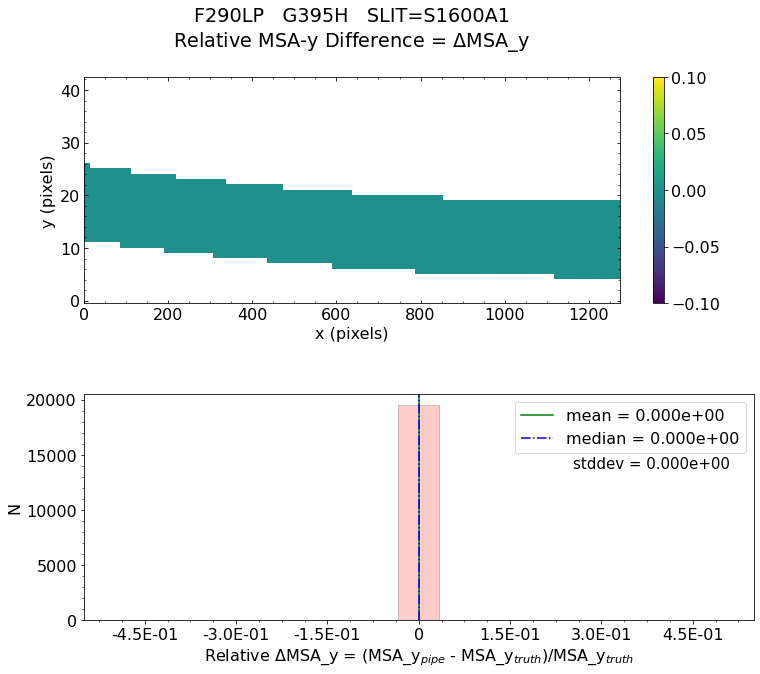

No output_directory was provided. Figures will NOT be saved.


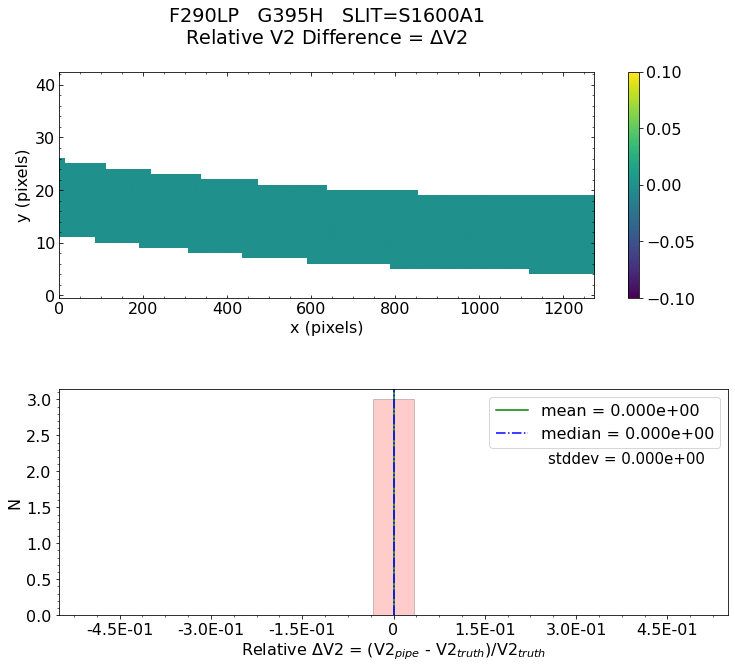

No output_directory was provided. Figures will NOT be saved.


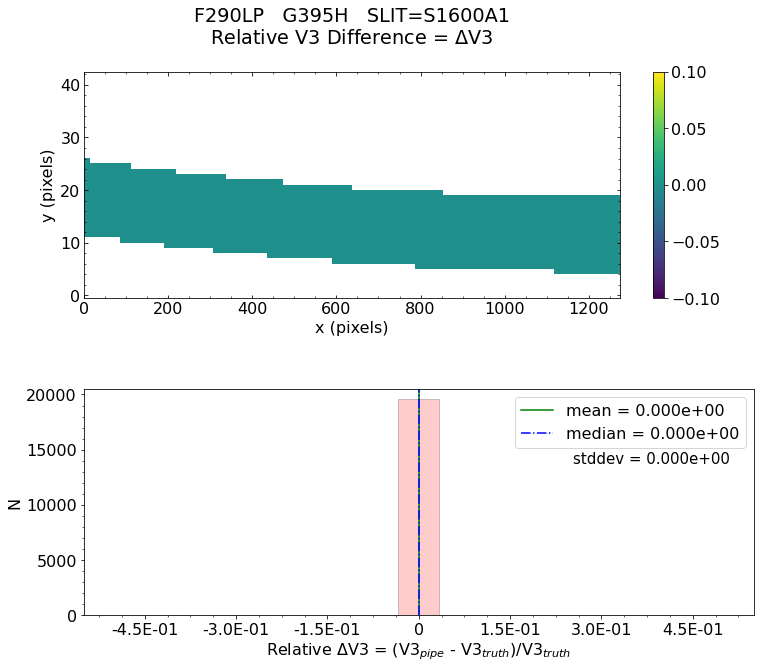


 * The test of V3 difference for slit S200A1 PASSED.

 * The test of V3 difference for slit S200A2 PASSED.

 * The test of V3 difference for slit S400A1 PASSED.

 * The test of V3 difference for slit S1600A1 PASSED.

 *** Final result for assign_wcs test will be reported as PASSED *** 



In [10]:
# Run the validation test
%matplotlib inline
result, _ = nptt.calwebb_spec2_pytests.auxiliary_code.compare_wcs_fs.compare_wcs(pipe_result, truth_file=truth_file, 
                                                                                 esa_files_path=esa_files_full_path, 
                                                                                 show_figs=show_figs,
                                                                                 save_figs=save_figs, 
                                                                                 threshold_diff=threshold_diff, 
                                                                                 raw_data_root_file=raw_data_root_file,
                                                                                 output_directory=None)

In [11]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation for FS FULL-FRAME test passed? ", result)

Did assign_wcs validation for FS FULL-FRAME test passed?  PASSED


<a id="ALLSLITS"></a>
# FS ALLSLITS test

In [ ]:
# Set the variables 
data_directory = os.path.join(test_data_path, 'FS_ALLSLITS/G140H_F100LP')
input_file = os.path.join(data_directory, 'final_output_caldet1_NRS1_F100LP.fits')
mode_used = 'FS'
output_directory = 'somewhere_to_save_the_plots'

In [ ]:
# ESA intermediary products
raw_data_root_file = 'NRSSDRK-ALLSLITS-5345150216_1_491_SE_2015-12-11T15h40m25.fits'
esa_files_path = os.path.join(vault_path, 'prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/')
esa_files_full_path = "".join([esa_files_path, mode_used, "_CV3/ESA_Int_products"])

# pipeline intermediary products
truth_file = os.path.join(data_directory, 'final_output_caldet1_NRS1_F100LP_assign_wcs_truth.fits')

if not compare_assign_wcs_and_extract_2d_with_esa:
    esa_files_path, raw_data_root_file = None, None
else:
    truth_file = None

In [ ]:
# Run the pipeline step
step_output_file = input_file.replace(".fits", "_assign_wcs.fits")
pipe_result = AssignWcsStep.call(input_file)
#pipe_result.save(step_output_file)   # this is to save the pipeline output to a file

In [ ]:
# Run the validation test
%matplotlib inline
result, _ = nptt.calwebb_spec2_pytests.auxiliary_code.compare_wcs_fs.compare_wcs(pipe_result, truth_file=truth_file, 
                                                                                 esa_files_path=esa_files_full_path, 
                                                                                 show_figs=show_figs,
                                                                                 save_figs=save_figs, 
                                                                                 threshold_diff=threshold_diff, 
                                                                                 raw_data_root_file=raw_data_root_file)

In [ ]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation test for FS ALLSLITS passed? ", result)


<a id="MOS"></a>
# MOS test

In [ ]:
# Set the variables 
data_directory = os.path.join(test_data_path, 'MOS/G140M_LINE1')
input_file = os.path.join(data_directory, 'final_output_caldet1_NRS1.fits')
mode_used = 'MOS'
msa_conf_name = os.path.join(data_directory,'V8460001000101_new_msa.fits')
output_directory = 'somewhere_to_save_the_plots'

In [ ]:
# ESA intermediary products
raw_data_root_file = 'NRSV84600010001P0000000002101_4_491_SE_2016-01-17T17h34m08.fits'
esa_files_path = os.path.join(vault_path, 'prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/')
esa_files_full_path = "".join([esa_files_path, mode_used, "_CV3/ESA_Int_products"])

# pipeline intermediary products
truth_file = os.path.join(data_directory, 'final_output_caldet1_NRS1_assign_wcs_truth.fits')

if not compare_assign_wcs_and_extract_2d_with_esa:
    esa_files_path, raw_data_root_file = None, None
else:
    truth_file = None
    

In [ ]:
# Run the pipeline step
step_output_file = input_file.replace(".fits", "_assign_wcs.fits")
pipe_result = AssignWcsStep.call(input_file)
#pipe_result.save(step_output_file)   # this is to save the pipeline output to a file

In [ ]:
# Run the validation test
%matplotlib inline
result, _ = nptt.calwebb_spec2_pytests.auxiliary_code.compare_wcs_mos.compare_wcs(pipe_result, 
                                                                                  msa_conf_name=msa_conf_name, 
                                                                                  truth_file=truth_file,
                                                                                  esa_files_path=esa_files_full_path, 
                                                                                  show_figs=show_figs, 
                                                                                  save_figs=save_figs, 
                                                                                  threshold_diff=threshold_diff,
                                                                                  mode_used=mode_used, 
                                                                                  raw_data_root_file=raw_data_root_file)

In [ ]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation for MOS test passed? ", result)


<a id="IFU"></a>
# IFU test

In [ ]:
# Set the variables 
data_directory = os.path.join(test_data_path, 'IFU_CV3/G395H_OPAQUE')
input_file = os.path.join(data_directory, 'final_output_caldet1_NRS1.fits')
mode_used = 'IFU'
output_directory = 'somewhere_to_save_the_plots'

In [ ]:
# ESA intermediary products
raw_data_root_file = 'NRSSMOS-MOD-G3H-18-5344134506_1_492_SE_2015-12-10T13h57m30.fits'
esa_files_path = os.path.join(vault_path, 'prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/')
esa_files_full_path = "".join([esa_files_path, mode_used, "_CV3/ESA_Int_products"])

# pipeline intermediary products
truth_file = os.path.join(data_directory, 'final_output_caldet1_NRS2_assign_wcs_truth.fits')

if not compare_assign_wcs_and_extract_2d_with_esa:
    esa_files_path, raw_data_root_file = None, None
else:
    truth_file = None
    

In [ ]:
# Run the pipeline step
step_output_file = input_file.replace(".fits", "_assign_wcs.fits")
pipe_result = AssignWcsStep.call(input_file)
#pipe_result.save(step_output_file)   # this is to save the pipeline output to a file

In [ ]:
# Run the validation test
%matplotlib inline
result, _ = nptt.calwebb_spec2_pytests.auxiliary_code.compare_wcs_ifu.compare_wcs(pipe_result, truth_file=truth_file, 
                                                                                  esa_files_path=esa_files_full_path, 
                                                                                  show_figs=show_figs,
                                                                                  save_figs=save_figs, 
                                                                                  threshold_diff=threshold_diff, 
                                                                                  raw_data_root_file=raw_data_root_file)

In [ ]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation test for IFU passed? ", result)


<a id="results"></a>
## Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.

<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Staff Scientist II - Systems Science Support, NIRSpec
<br>**Updated On:** Sept/25/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 